In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import warnings
from statsmodels.tsa.seasonal import STL
import optuna

from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from pmdarima.arima import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
plt.style.use('fivethirtyeight')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Forecasting Average Player Count for Steam Games
## Project Overview

In this project, we will develop a model to forecast the average player count for a specific Steam game in a given month. The process involves data exploration, preprocessing, feature engineering, and finally, building a sophisticated machine learning pipeline. By predicting player counts, we aim to provide insights into player engagement, which can inform decisions related to marketing strategies.
Authors
- Aden Letchworth
- Fienna Angeline
- Gabriel Bermudez

## Dataset Overview

- Name of the Dataset: Popularity of Games on Steam
- Dataset URL: View Dataset
- License: CC0: Public Domain
- Features:
    - gamename - The title of the game.
    - year - Observation year.
    - month - Observation month.
    - avg - Average number of concurrent players.
    - gain - Change in average player count from the previous month.
    - peak - Maximum number of concurrent players.
    - avg_peak_perc - Percentage of average players relative to the peak count.

## Methodology

The project will start with a thorough data exploration to understand the dynamics of player counts across different games. After initial exploration, the data will undergo preprocessing and feature engineering to prepare it for modeling. We will use Optuna to optimize a machine learning pipeline that includes models like XGBoost, RandomForest, and SARIMA, combined into a stacked model with a Linear Regression meta-model. The performance of the stacked model will be compared against individual models and a neural network approach using LSTM to establish the most effective forecasting method.

## Data Exploration

In this initial phase of our project, we'll look into the dataset to understand its structure and identify potential preprocessing and feature engineering strategies. This thorough examination will set the foundation for our analytical approach and ensure we handle the data effectively to optimize our forecasting model.

In [47]:
# Load the data
data_path = './Data/SteamCharts 2.csv'
df = pd.read_csv(data_path, encoding='unicode_escape') # Needs special encoding to read the file

In [48]:
df.head()

,gamename,year,month,avg,gain,peak,avg_peak_perc
0,Counter-Strike: Global Offensive,2021,February,741013.24,-2196.42,1123485,65.9567%
1,Counter-Strike: Global Offensive,2021,January,743209.66,25405.91,1124553,66.0893%
2,Counter-Strike: Global Offensive,2020,December,717803.75,49049.17,1164396,61.646%
3,Counter-Strike: Global Offensive,2020,November,668754.58,55087.89,1037464,64.4605%
4,Counter-Strike: Global Offensive,2020,October,613666.69,6816.37,943876,65.0156%


Upon examining the first few entries of our dataset, we observe six columns, consistent with our dataset description. Key observations include the need to format the `avg_peak_perc` column to remove the percentage symbol for computational convenience. The gamename column will require encoding to transform categorical data into a machine-readable format. The month field should be converted to a numerical format for easier analysis, and it would be beneficial to create a consolidated date column from the year and month fields to aid in time-series visualization and modeling

In [49]:
df.query('year == 2020')

,gamename,year,month,avg,gain,peak,avg_peak_perc
2,Counter-Strike: Global Offensive,2020,December,717803.75,49049.17,1164396,61.646%
3,Counter-Strike: Global Offensive,2020,November,668754.58,55087.89,1037464,64.4605%
4,Counter-Strike: Global Offensive,2020,October,613666.69,6816.37,943876,65.0156%
5,Counter-Strike: Global Offensive,2020,September,606850.32,-33107.34,977769,62.0648%
6,Counter-Strike: Global Offensive,2020,August,639957.66,14056.85,925348,69.1586%
...,...,...,...,...,...,...,...
83750,Steel Division: Normandy 44,2020,May,143.79,19.94,353,40.7337%
83751,Steel Division: Normandy 44,2020,April,123.85,-2.47,244,50.7582%
83752,Steel Division: Normandy 44,2020,March,126.32,24.71,280,45.1143%
83753,Steel Division: Normandy 44,2020,February,101.61,-4.10,231,43.987%


Further querying reveals that our dataset includes entries for multiple games each month, rather than just the most popular game per month. This structure necessitates aggregation by gamename during preprocessing to ensure that our model captures trends specific to each game. This multi-game per date format increases the complexity of our preprocessing steps, as we need to account for inter-game variations when aggregating data.

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83789 entries, 0 to 83788
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gamename       83789 non-null  object 
 1   year           83789 non-null  int64  
 2   month          83789 non-null  object 
 3   avg            83789 non-null  float64
 4   gain           82529 non-null  float64
 5   peak           83789 non-null  int64  
 6   avg_peak_perc  83789 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 4.5+ MB


This shows our dataset dimensions as (83789, 7), indicating a good dataset size that supports a wide variety of model types without significant limitations. However, as noted earlier, the `avg_peak_perc` column still requires parsing to convert it from a string to a numeric format. Apart from this, the data types appear appropriate for our subsequent analyses, setting a solid stage for the preprocessing phase.

In [51]:
# Get missing values per column
df.isna().sum()

gamename            0
year                0
month               0
avg                 0
gain             1260
peak                0
avg_peak_perc       0
dtype: int64

We can see we have quite a few missing values for the `gain` column, which isn't a problem because we can impute it using calculations. Since we are going to due preprocessing that this gain is dependent on, we will drop it for now then add it back on later to ensure data integrity is maintained. 

In [52]:
# Drop gain column
df.drop(['gain'], axis=1, inplace=True)

In [53]:
df['avg_peak_perc'] = df['avg_peak_perc'].str.rstrip('%').astype(float) / 100

Before we can visualize our data efficiently we must create a date type and make it the index of our dataframe. In the following code cell, we are going to map the months to their corresponding numerical representations. We will then combine `year` with `month` to create `date` which will be sorted as our index.

In [54]:
#Encodes Months to Numbers
month_to_num = { 
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Convert month to numerical representation
df['month'] = df['month'].str.strip() # Strip whitespace
df['month'] = df['month'].map(month_to_num) # Map month names to numbers

# Add date column and make it df index 
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

In [55]:
# Calculate global averages
global_avg = df.groupby('date')['avg'].mean()
global_peak = df.groupby('date')['peak'].mean()
global_avg_peak_perc = df.groupby('date')['avg_peak_perc'].mean()

df['date'] = df.index

# Map global averages back to the corresponding columns
df['avg'] = df['date'].map(global_avg)
df['peak'] = df['date'].map(global_peak)
df['avg_peak_perc'] = df['date'].map(global_avg_peak_perc)

# Drop duplicates 
df = df.drop_duplicates(subset=['date', 'avg', 'peak', 'avg_peak_perc'])
df.drop('gamename', axis=1, inplace=True)

df.head(20)

,year,month,avg,peak,avg_peak_perc,date
date,,,,,,
2012-07-01,2012,7,2087.497843,3719.946078,0.464471,2012-07-01
2012-08-01,2012,8,1877.019767,3762.600000,0.451802,2012-08-01
2012-09-01,2012,9,1928.878836,4028.616379,0.409500,2012-09-01
2012-10-01,2012,10,1695.099350,4081.666667,0.376651,2012-10-01
2012-11-01,2012,11,1725.741120,3823.347490,0.354860,2012-11-01
2012-12-01,2012,12,1879.577844,4020.765799,0.347141,2012-12-01
2013-01-01,2013,1,2027.081392,4234.428571,0.360723,2013-01-01
2013-02-01,2013,2,1826.596512,3605.975089,0.392439,2013-02-01
2013-03-01,2013,3,1831.336225,3900.096026,0.359327,2013-03-01


Text(0.5, 1.0, 'Average Players Per Month')

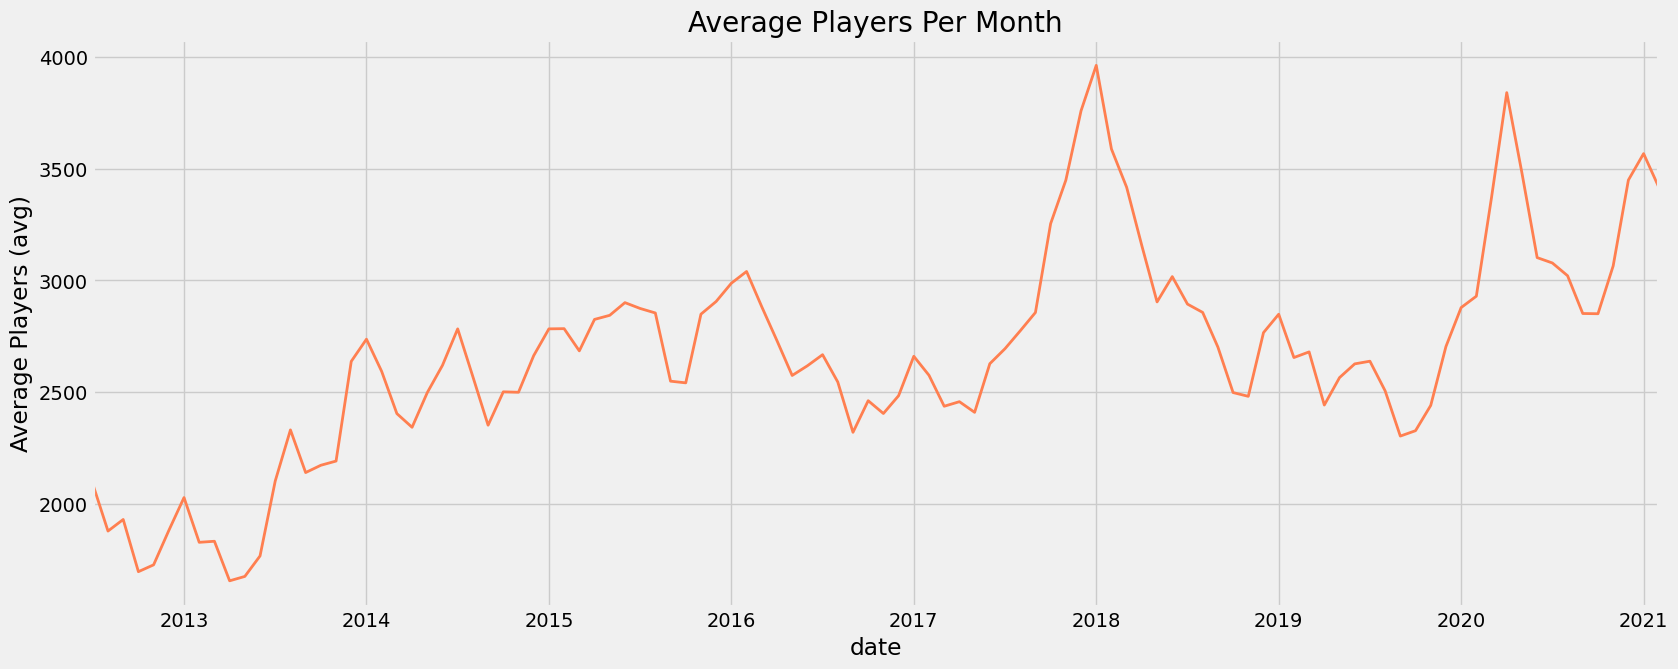

In [63]:
fig, ax = plt.subplots(figsize=(18,7))
df['avg'].plot(color='coral', ax=ax)
ax.set_ylabel('Average Players (avg)')
ax.set_title('Average Players Per Month')

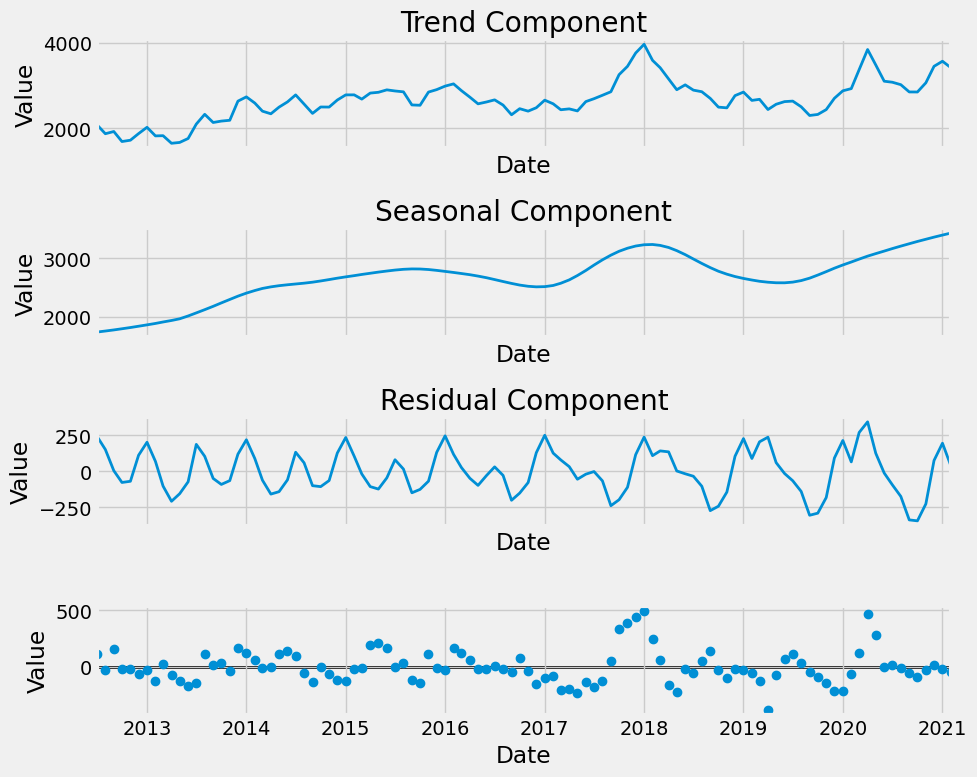

In [59]:
# Apply STL
stl = STL(df['avg'], seasonal=13)  
result = stl.fit()

# Add STL features to df
df['trend'] = result.trend
df['seasonal'] = result.seasonal
df['residual'] = result.resid

plt.rc('lines', linewidth=2) 

fig = result.plot() 
fig.set_figheight(8)  
fig.set_figwidth(10) 

axes = fig.get_axes() 
axes[0].set_title('Trend Component')  
axes[1].set_title('Seasonal Component')  
axes[2].set_title('Residual Component')  

for ax in axes:
    ax.set_xlabel('Date')  
    ax.set_ylabel('Value') 
    ax.grid(True)  

plt.tight_layout()  
plt.show()  

In [ ]:
# def cap_outliers(df, threshold=3):
#     # Group by 'gamename' and apply capping for each group
#     def cap_group(group):
#         for col in ['avg', 'peak']:
#             mean = group[col].mean()
#             std = group[col].std()
#             cap_upper = mean + threshold * std
#             cap_lower = mean - threshold * std
#             group[col] = group[col].clip(lower=cap_lower, upper=cap_upper)
#         return group

#     return df.groupby('gamename').apply(cap_group)

# df = cap_outliers(df, 25)
# df = df.drop(['gamename'], axis=1).reset_index('gamename')
# df.head()

Text(0.5, 1.0, 'Peak Players Per Month')

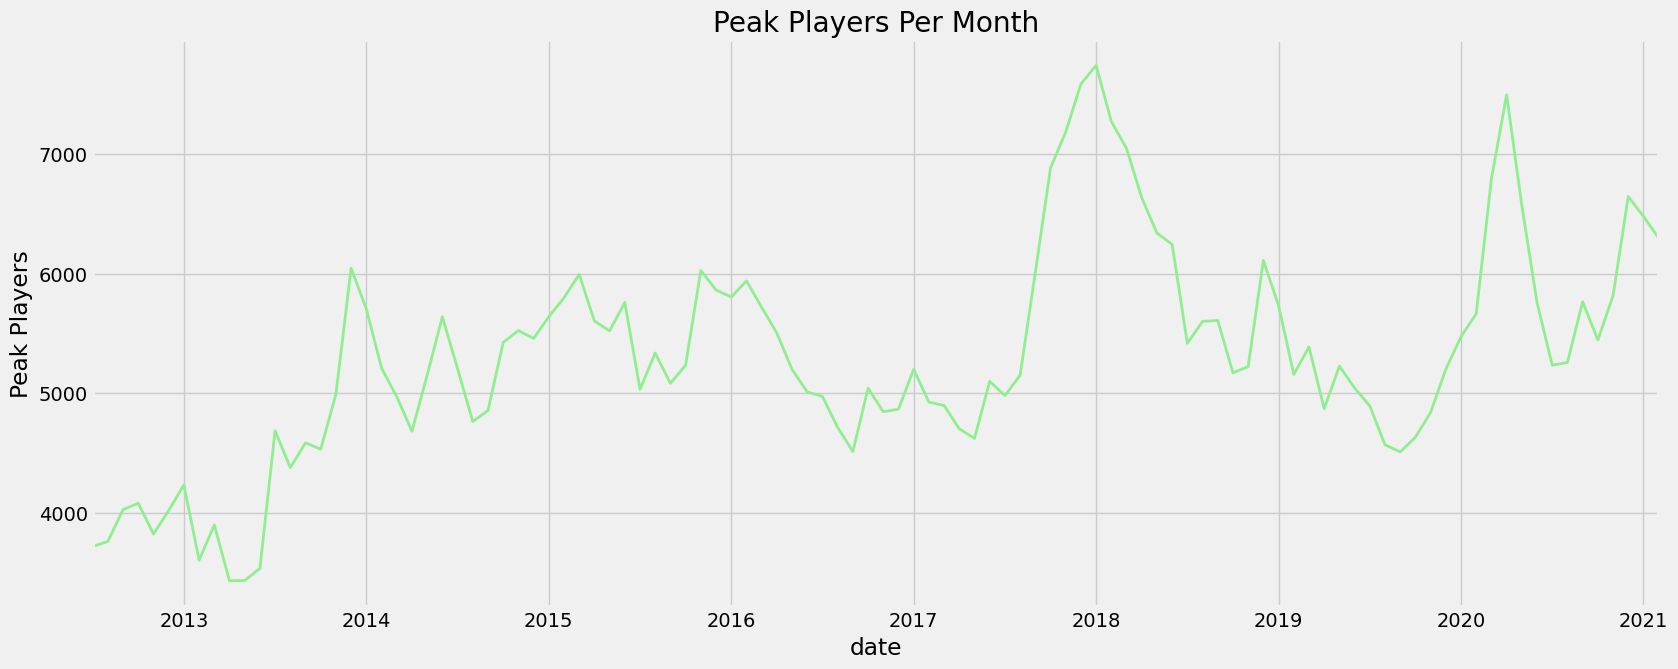

In [65]:
fig, ax = plt.subplots(figsize=(18,7))
df['peak'].plot(color='lightgreen', ax=ax)
ax.set_ylabel('Peak Players')
ax.set_title('Peak Players Per Month')

In [66]:
df['gain'] = df['avg'].pct_change() * 100
df = df.replace([np.inf, -np.inf], np.nan)

In [67]:
df.isna().sum()

year             0
month            0
avg              0
peak             0
avg_peak_perc    0
date             0
gain             1
dtype: int64

Text(0.5, 1.0, 'Gain of Steam Games Popularity')

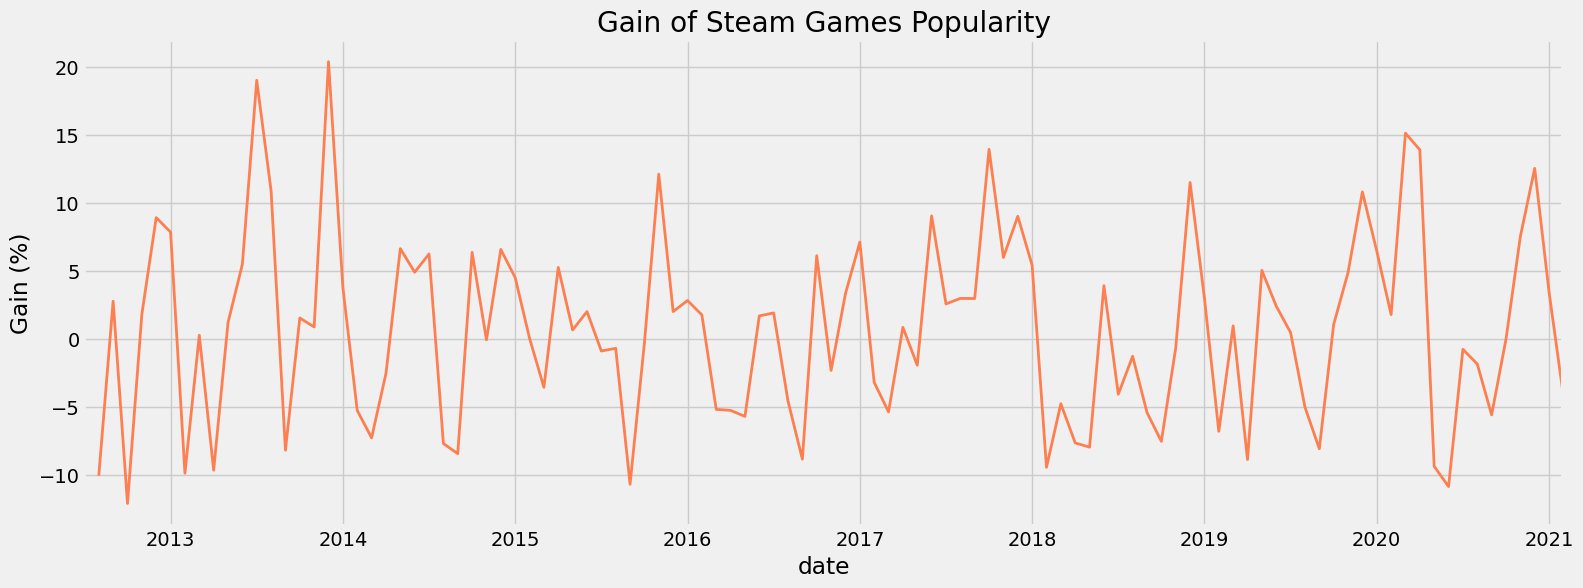

In [70]:
fig, ax = plt.subplots(figsize=(17, 6))

df['gain'].plot(ax=ax, color='coral', label='Gain')
ax.set_ylabel('Gain (%)')
ax.set_title('Gain of Steam Games Popularity')

In [ ]:
df = df.sort_values(by=['gamename', 'date'])

# Calculate global features across all games for each date
global_avg = df.groupby('date')['avg'].mean().rename('global_avg')
global_gain = df.groupby('date')['gain'].mean().rename('global_gain')
global_peak = df.groupby('date')['peak'].mean().rename('global_peak')
global_avg_peak_perc = df.groupby('date')['avg_peak_perc'].mean().rename('global_avg_peak_perc')

# Join these global features back to the original dataframe
for feature in ['global_avg', 'global_gain', 'global_peak', 'global_avg_peak_perc']:
    df = df.merge(eval(feature).reset_index(), on='date', how='left')

# Create lag features for both global and game-specific
features = ['avg', 'gain', 'peak', 'avg_peak_perc']
for feature in features:
    df[f'global_{feature}_lag_1'] = df[f'global_{feature}'].shift(1)
    df[f'global_{feature}_lag_2'] = df[f'global_{feature}'].shift(2)



# Calculate rolling averages and standard deviations for 7 and 30 day windows
features = ['global_avg']
rolling_windows = [7, 30]
for window in rolling_windows:
    for feature in features:
        df[f'{feature}_rolling_{window}'] = df[feature].rolling(window=window, min_periods=1).mean()
        df[f'std_rolling_{window}'] = df[feature].rolling(window=window, min_periods=1).std()


df.index=df['date']
imputer = KNNImputer(n_neighbors=5, weights='uniform')

# # Columns to impute
columns_to_impute = [col for col in df.columns if df[col].isna().sum() > 0]

# Impute each group separately and update the DataFrame
for name, group in df.groupby('gamename'):
    # Perform imputation
    imputed_data = imputer.fit_transform(group[columns_to_impute])
    # Ensure the output is a DataFrame that matches the original in terms of columns
    imputed_df = pd.DataFrame(imputed_data, columns=columns_to_impute, index=group.index)
    # Update the original DataFrame
    df.loc[group.index, columns_to_impute] = imputed_df
    
df.isna().sum()

date                          0
gamename                      0
year                          0
month                         0
avg                           0
peak                          0
avg_peak_perc                 0
trend                         0
seasonal                      0
resid                         0
gain                          0
global_avg                    0
global_gain                   0
global_peak                   0
global_avg_peak_perc          0
global_avg_lag_1              0
global_avg_lag_2              0
global_gain_lag_1             0
global_gain_lag_2             0
global_peak_lag_1             0
global_peak_lag_2             0
global_avg_peak_perc_lag_1    0
global_avg_peak_perc_lag_2    0
global_avg_rolling_7          0
std_rolling_7                 0
global_avg_rolling_30         0
std_rolling_30                0
dtype: int64

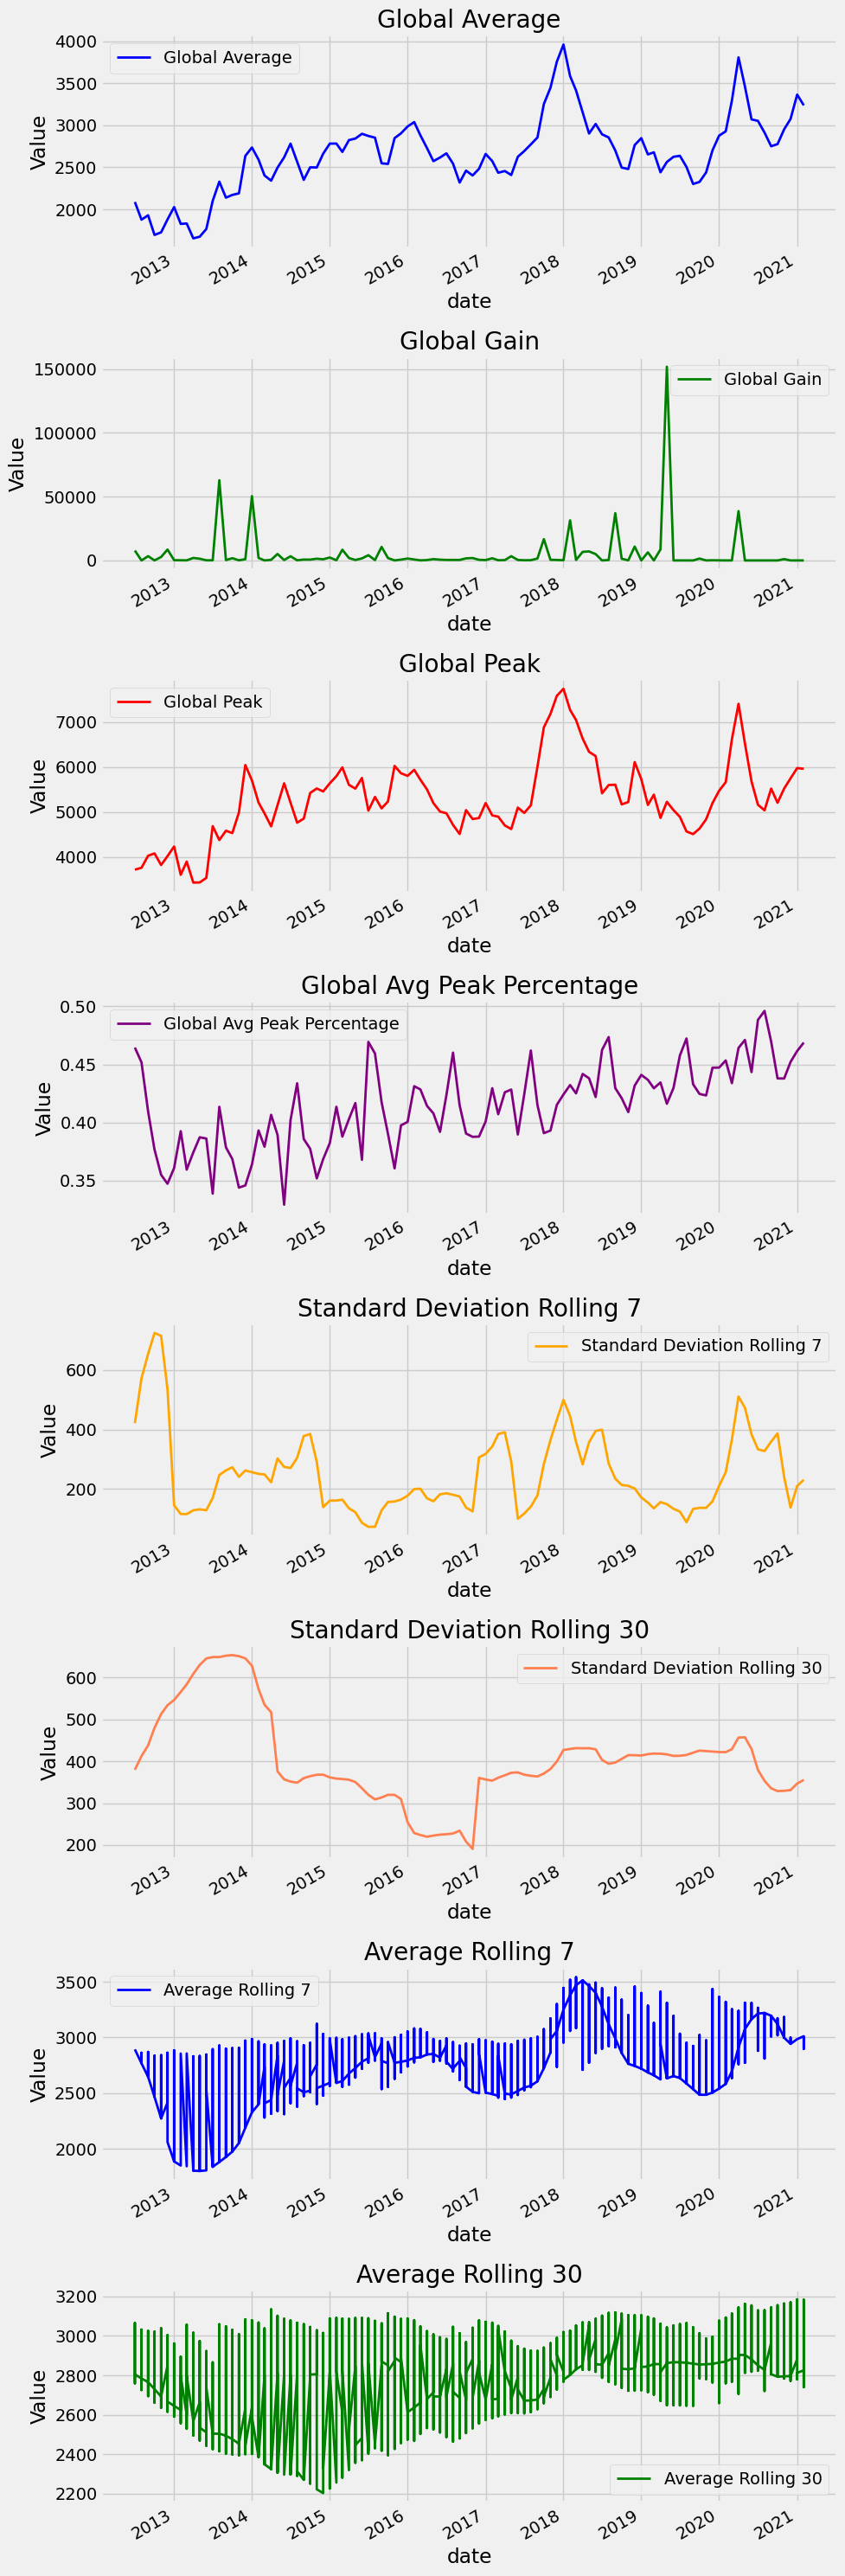

In [ ]:
fig, axs = plt.subplots(8, 1, figsize=(10, 30))  # Adjust the size as necessary

# Plot each global feature on a separate subplot
df['global_avg'].plot(ax=axs[0], color='blue', label='Global Average')
axs[0].set_title('Global Average')
axs[0].set_ylabel('Value')
axs[0].legend()

df['global_gain'].plot(ax=axs[1], color='green', label='Global Gain')
axs[1].set_title('Global Gain')
axs[1].set_ylabel('Value')
axs[1].legend()

df['global_peak'].plot(ax=axs[2], color='red', label='Global Peak')
axs[2].set_title('Global Peak')
axs[2].set_ylabel('Value')
axs[2].legend()

df['global_avg_peak_perc'].plot(ax=axs[3], color='purple', label='Global Avg Peak Percentage')
axs[3].set_title('Global Avg Peak Percentage')
axs[3].set_ylabel('Value')
axs[3].legend()

df['std_rolling_7'].plot(ax=axs[4], color='orange', label='Standard Deviation Rolling 7')
axs[4].set_title('Standard Deviation Rolling 7')
axs[4].set_ylabel('Value')
axs[4].legend()

df['std_rolling_30'].plot(ax=axs[5], color='coral', label='Standard Deviation Rolling 30')
axs[5].set_title('Standard Deviation Rolling 30')
axs[5].set_ylabel('Value')
axs[5].legend()

df['global_avg_rolling_7'].plot(ax=axs[6], color='blue', label='Average Rolling 7')
axs[6].set_title('Average Rolling 7')
axs[6].set_ylabel('Value')
axs[6].legend()

df['global_avg_rolling_30'].plot(ax=axs[7], color='green', label='Average Rolling 30')
axs[7].set_title('Average Rolling 30')
axs[7].set_ylabel('Value')
axs[7].legend()

# Automatically adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
# Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df["global_avg"], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   -38.773605
p-value                            0.000000
#Lags Used                        65.000000
Number of Observations Used    83121.000000
Critical Value (1%)               -3.430429
Critical Value (5%)               -2.861575
Critical Value (10%)              -2.566789
dtype: float64


In [ ]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df["global_avg"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         m=12,
                         start_P=0,
                         seasonal=True,
                         d=None,
                         D=1, 
                         trace=False,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True
)

KeyboardInterrupt: 

In [ ]:
scaled_rows = [col for col in df.columns if col not in ['date', 'gamename', 'year', 'month', 'global_avg']]

# Define Scaler object
scaler = StandardScaler()

# Function to apply scaling to each group
def scale_group(group):
    group[scaled_rows] = scaler.fit_transform(group[scaled_rows])
    return group

# Apply scaler to each group
df = df.groupby('gamename').apply(scale_group)

df.head()

date  gamename  year  month       avg      peak  \
gamename date                                                               
0.0      2014-03-01 2014-03-01       0.0  2014      3 -1.556264 -1.195005   
         2014-04-01 2014-04-01       0.0  2014      4 -1.557029 -1.199214   
         2014-05-01 2014-05-01       0.0  2014      5 -1.293316 -0.881382   
         2014-06-01 2014-06-01       0.0  2014      6 -1.159355 -0.759300   
         2014-07-01 2014-07-01       0.0  2014      7 -0.972529 -0.788768   

                     avg_peak_perc     trend  seasonal     resid  ...  \
gamename date                                                     ...   
0.0      2014-03-01       0.440920 -1.444591 -1.294391  0.189576  ...   
         2014-04-01       0.573275 -1.425793 -1.713882  0.537219  ...   
         2014-05-01      -3.414919 -1.404589 -1.093322  0.498227  ...   
         2014-06-01       0.002426 -1.381098  0.943227 -1.097674  ...   
         2014-07-01       0.701227 -1.355676  0.067176  0.047363  ...   

                     global_gain_lag_1  global_gain_lag_2  global_peak_lag_1  \
gamename date                                                                  
0.0      2014-03-01          -0.147583           2.473485          -0.476022   
         2014-04-01          -0.258493          -0.173809          -0.810733   
         2014-05-01          -0.258835          -0.280262           0.572328   
         2014-06-01          -0.258835          -0.280262           0.572328   
         2014-07-01          -0.241944          -0.280901           0.122198   

                     global_peak_lag_2  global_avg_peak_perc_lag_1  \
gamename date                                                        
0.0      2014-03-01           0.185237                   -0.965747   
         2014-04-01          -0.506430                   -1.399504   
         2014-05-01           0.569217                    1.380245   
         2014-06-01           0.569217                    1.380245   
         2014-07-01           0.546972                   -2.946752   

                     global_avg_peak_perc_lag_2  global_avg_rolling_7  \
gamename date                                                           
0.0      2014-03-01                   -1.879602             -1.324428   
         2014-04-01                   -0.976668             -1.435134   
         2014-05-01                    1.129368             -1.285257   
         2014-06-01                    1.129368             -1.100076   
         2014-07-01                    1.352747             -0.871072   

                     std_rolling_7  global_avg_rolling_30  std_rolling_30  
gamename date                                                              
0.0      2014-03-01       0.107739              -2.471014        2.473348  
         2014-04-01      -0.134979              -2.707262        2.216624  
         2014-05-01       0.601971              -2.387422        0.167338  
         2014-06-01       0.341062              -1.992248       -0.111620  
         2014-07-01       0.305609              -1.503553       -0.187120  

[5 rows x 27 columns]

In [ ]:
df = df.drop('date', axis=1).reset_index('date')
df.to_csv('clean_data.csv', index=False)

In [ ]:
df = df.drop(['gamename', 'date'], axis=1).reset_index('gamename')

In [ ]:
def tune_rf():
    def objective(trial):
        # Define hyperparameters for the RandomForestRegressor
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_float('max_features', 0.1, 1.0)
        }

        # Define the RandomForestRegressor model
        model = RandomForestRegressor(**params)

        # TimeSeriesSplit setup
        n_splits = 3
        tscv = TimeSeriesSplit(n_splits=n_splits)
        rmses = []

        for train_index, test_index in tscv.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]

            # Split data into X and y
            X_train, y_train = train.drop('global_avg', axis=1), train['global_avg']
            X_test, y_test = test.drop('global_avg', axis=1), test['global_avg']

            # Train model
            model.fit(X_train, y_train)
            # Evaluate the model
            preds = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, preds))
            rmses.append(rmse)

        # Calculate average RMSE across all folds
        return np.mean(rmses)


    # Create optuna study with Hyperband pruner and TPE sampler
    study = optuna.create_study(
        direction='minimize',
        pruner=optuna.pruners.HyperbandPruner(),
        sampler=optuna.samplers.TPESampler()
    )

    # Optimize the study
    study.optimize(objective, n_trials=100)

    # Print out best parameters
    print("Best trial:")
    trial = study.best_trial
    print(f" Value: {trial.value}")
    print(" Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
tune_rf()

[I 2024-05-09 10:28:28,011] A new study created in memory with name: no-name-c013df39-acb1-4dca-9909-32c0366b03bc
[W 2024-05-09 10:29:20,314] Trial 0 failed with parameters: {'n_estimators': 174, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.8425946588063051} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/67/lkv3fsr91pqgg56l3dkwrl300000gp/T/ipykernel_97769/4031359493.py", line 29, in objective
    model.fit(X_train, y_train)
  File "/usr/local/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/sklearn/ensemble/_forest.py", line 456, in fit
    trees = Parallel(


KeyboardInterrupt: 

In [ ]:
'n_estimators': 253, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 0.5911917164805567

In [ ]:
def tune_xgb():
    def objective(trial):
        # Define hyperparameters for the XGBRegressor
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
        }

        # Define the XGBRegressor model
        model = xgb.XGBRegressor(**params)

        # TimeSeriesSplit setup
        n_splits = 3
        tscv = TimeSeriesSplit(n_splits=n_splits)
        rmses = []

        for train_index, test_index in tscv.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]

            # Split data into X and y
            X_train, y_train = train.drop('avg', axis=1), train['avg']
            X_test, y_test = test.drop('avg', axis=1), test['avg']

            # Train model
            model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)
            # Evaluate the model
            preds = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, preds))
            rmses.append(rmse)

        # Calculate average RMSE across all folds
        return np.mean(rmses)

    # Create optuna study with Hyperband pruner and TPE sampler
    study = optuna.create_study(
        direction='minimize',
        pruner=optuna.pruners.HyperbandPruner(),
        sampler=optuna.samplers.TPESampler()
    )

    # Optimize the study
    study.optimize(objective, n_trials=100)

    # Print out best parameters
    print("Best trial:")
    trial = study.best_trial
    print(f" Value: {trial.value}")
    print(" Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
tune_xgb()

[I 2024-05-08 11:47:27,477] A new study created in memory with name: no-name-a5ec69a1-3390-4bfd-be50-f81931baab7c
[W 2024-05-08 11:49:57,387] Trial 0 failed with parameters: {'n_estimators': 509, 'max_depth': 9, 'learning_rate': 0.0978163404050783, 'subsample': 0.8062651734102195, 'colsample_bytree': 0.8745114350790755, 'min_child_weight': 3} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/67/lkv3fsr91pqgg56l3dkwrl300000gp/T/ipykernel_97769/1366500579.py", line 30, in objective
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=50, verbose=False)
  File "/usr/local/lib/python3.11/site-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages

KeyboardInterrupt: 

In [ ]:
rf_params = {
    'n_estimators': 140, 
    'max_depth': 11, 
    'min_samples_split': 3, 
    'min_samples_leaf': 1, 
    'max_features': 0.7052178520527116
}

xgb_params = {'n_estimators': 923, 'max_depth': 9, 'learning_rate': 0.011403455328877099, 'subsample': 0.5821533644530206, 'colsample_bytree': 0.8555895213036614, 'min_child_weight': 7}

# Define other params for models
...


# Put the models into the estimators base
estimators = [
    ('xgb', xgb.XGBRegressor(**xgb_params)),
    ('rf', RandomForestRegressor(**rf_params))
]

# Meta estimator decides how to combine the base estimators
meta_estimator = LinearRegression()

# Define the stacking regressor
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=meta_estimator)

# Define the features and target variable
features = df.drop('avg', axis=1)
target = df['avg']

# Define the TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
scores_rf = []
scores_xgb = []
scores_stacked = []

for train_idx, test_idx in tscv.split(features):
    X_train, X_test = features.iloc[train_idx], features.iloc[test_idx]
    y_train, y_test = target.iloc[train_idx], target.iloc[test_idx]
    
    # Random Forest model
    model_rf = RandomForestRegressor(**rf_params)
    model_rf.fit(X_train, y_train)
    y_pred_rf = model_rf.predict(X_test)
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    scores_rf.append(rmse_rf)

    # XGBoost model
    model_xgb = xgb.XGBRegressor(**xgb_params)
    model_xgb.fit(X_train, y_train)
    y_pred_xgb = model_xgb.predict(X_test)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    scores_xgb.append(rmse_xgb)

    # Stacked model
    stacking_regressor.fit(X_train, y_train)
    y_pred_stacked = stacking_regressor.predict(X_test)
    rmse_stacked = np.sqrt(mean_squared_error(y_test, y_pred_stacked))
    scores_stacked.append(rmse_stacked)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(scores_rf, label='Random Forest', marker='o')
ax.plot(scores_xgb, label='XGBoost', marker='o')
ax.plot(scores_stacked, label='Stacked Model', marker='o')
ax.set_title('Model Comparison - RMSE Across Time Splits')
ax.set_xlabel('Time Split')
ax.set_ylabel('RMSE')
ax.legend()
plt.show()